In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as sc

In [2]:
#Constats
#Material
decanol1 = {'m':158.285,
            'n_atom':33,
            'DOF':99,
            'rho_l':830,
            'c_l': 1600,
            'p*':1.3,
            'T*':298.15,
            'deltaH_vap':8.1*10**4}

#Chamber
chamber = {'Volume V_ch':10**(-2),
           'Surface area A_ch':0.7,
           'Pumping speed S_p':50*10**(-3),
           'wall leak flux j_w':3*10**12,
           'liquid vol V_l':3,#*10**(-6),
           'surface area A_l':4.66*10**(-4)}

#Set parameters in use
m, n_atom, D, rho_l, c_l, p_star, T_star, deltaH_vap = decanol1.values()
V_ch, A_ch, S_p, j_w, V_l, A_l = chamber.values()
t_s = 10**3 #tau_s


#Start values
T_l = 305
P_v = 0.7
T_v = 298

In [3]:
def P_sat(T):
    if T <= T_star:
        raise ValueError('T must be bigger than T*')
    else:
        return p_star * np.log(- deltaH_vap / (sc.k * sc.N_A) * (1/T - 1/T_star))

def j_ev():
    sigma_e = P_sat(T_l) / P_v * np.exp( (D+4) * (1 - T_v/T_l) ) * (T_v/T_l)**(D+4)
    sigma_c = np.sqrt(T_v/T_l) * np.exp( -(D+4) * (1 - T_v/T_l) ) * (T_v/T_l)**(-(D+4))
    
    return np.sqrt(1/(2*np.pi*m*sc.k)) * ( sigma_e * P_sat(T_l)/np.sqrt(T_l) - sigma_c * P_v/np.sqrt(T_l) )

def delta_valve(t):
    if t > 10:
        return 0
    else:
        return 1

def dpdt(j_ev, delta_valve):
    # print(A_l/V_ch * sc.k * T_v * j_ev)
    # print(A_ch/V_ch * sc.k * T_v * j_w)
    # print(- S_p/V_ch * P_v * delta_valve)
    return A_l/V_ch * sc.k * T_v * j_ev + A_ch/V_ch * sc.k * T_v * j_w - S_p/V_ch * P_v * delta_valve

def dTdt(j_ev):
    return - ( A_l * deltaH_vap) / ( sc.N_A * rho_l * V_l * c_l) * j_ev + ( T_v - T_l) / t_s

def dVdt(j_ev):
    return - m/(rho_l * A_l) * j_ev

In [5]:
#Set parameters in use
m, n_atom, D, rho_l, c_l, p_star, T_star, deltaH_vap = decanol1.values()
V_ch, A_ch, S_p, j_w, V_l, A_l = chamber.values()
t_s = 10**3 #tau_s
m = m * 1.66053907*10**(-27)
# D = 0
#Start values
T_l = 30+273.15
P_v = 0.7
T_v = 273.15 + 35

pressure = [P_v]
liquid_temparature = [T_l]
liquid_volume = [V_l]
time = np.linspace(10**(-1), 10**4, 1000000)

for t in range(len(time)):
    #Calc j_ev
    sigma_e = P_sat(T_l) / P_v * np.exp( (D+4) * (1 - T_v/T_l) ) * (T_v/T_l)**(D+4)
    sigma_c = np.sqrt(T_v/T_l) * np.exp( -(D+4) * (1 - T_v/T_l) ) * (T_v/T_l)**(-(D+4))
    j = np.sqrt(1/(2*np.pi*m*sc.k)) * ( sigma_e * P_sat(T_l)/np.sqrt(T_l) - sigma_c * P_v/np.sqrt(T_l) )
    # print(j)
    # print(t, time[t])
    valve = delta_valve(time[t])
    if t == 0:
        delta = abs(0.01)
    else:
        delta = abs(time[t]-time[t-1])
    #Calculate change
    dp = A_l/V_ch * sc.k * T_v * j + A_ch/V_ch * sc.k * T_v * j_w - S_p/V_ch * P_v * valve
    dT =  - ( A_l * deltaH_vap) / ( sc.N_A * rho_l * V_l * c_l) * j + ( T_v - T_l) / t_s
    dV = - m/(rho_l * A_l) * j

    # print(P_v,T_l,V_l)
    #Add change to value
    P_v += dp*delta
    T_l += dT*delta
    V_l += dV*delta

    #Add to list
    pressure.append(P_v)
    liquid_temparature.append(T_l)
    liquid_volume.append(V_l)

    
    #print(dp,dT,dV, valve,j, delta)
    print(A_ch/ V_ch * sc.k* T_v)
    # print(P_v, T_l, V_l)
    # print()
    if t == 2:
        break



2.97812892545e-19
2.97812892545e-19
2.97812892545e-19


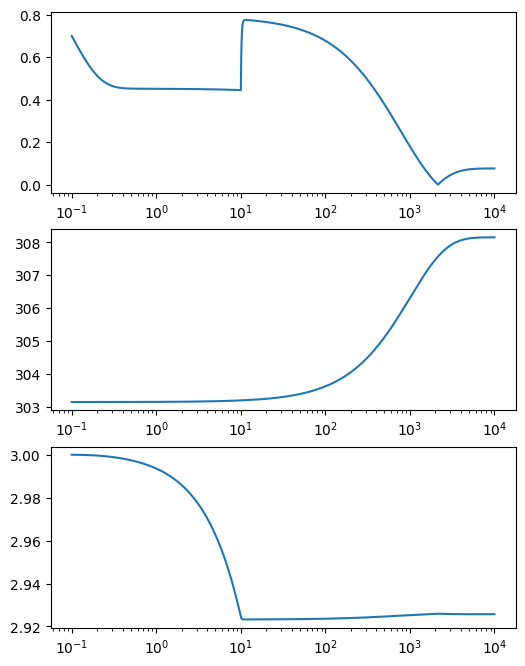

In [10]:
runs = len(pressure)
fig, axes = plt.subplots(3,1, figsize=(6,8))
axes[0].set_xscale("log")
axes[0].plot(time[:runs], pressure[:-1])

axes[1].set_xscale("log")
axes[1].plot(time[:runs], liquid_temparature[:-1])

axes[2].set_xscale("log")
axes[2].plot(time[:runs], liquid_volume[:-1])
# axes[2].set_ylim(2.99,3.01)

In [105]:
liquid_volume

[1,
 1.0000359768143907,
 1.0000662353083964,
 1.000091040209844,
 1.000110638599367,
 1.0001252639064184,
 1.0001351394280265,
 1.0001404816617958,
 1.000141503344584,
 1.0001384160749145,
 1.0001314323961168,
 1.0001207672319596,
 1.0001066385986694,
 1.0000892675649875,
 1.0000688774901074,
 1.0000456926297356,
 1.0000199362535476,
 0.9999918284542577,
 0.9999615838436212,
 0.9999294093225889,
 0.9998955020845921,
 0.9998600479689591,
 0.9998232202336279,
 0.9997851787700822,
 0.9997460697444018,
 0.9997060256196254,
 0.9996651654970342,
 0.9996235957064332,
 0.9995814105759339,
 0.999538693317675,
 0.9994955169750425,
 0.9994519453873685,
 0.9994080341384568,
 0.9993638314647229,
 0.9993193791068085,
 0.999274713095085,
 0.9992298644645362,
 0.9991848598982742,
 0.999139722301593,
 0.9990944713102221,
 0.9990491237375089,
 0.9990036939658049,
 0.9989581942875103,
 0.9989126352011495,
 0.9988670256676027,
 0.9988213733312697,
 0.998775684710539,
 0.9987299653615103,
 0.9986842200185